# Plant disease detection (diseased or healthy)

# Imports

In [1]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import math
import time
from PIL import Image

Using TensorFlow backend.
/opt/student/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Defining parameters and Initializing variables

Different hyper parameters values are set and variables are initialized

In [2]:
batch_size = 64
num_classes = 2
epochs = 2

label_map_dict = {0 : 'healthy', 1 : 'diseased'}
image_data_list = []
labels = []
cost_list = []

# Getting data

Paths of images and there corresponding labels are stored in lists.
List of image paths is later used to load images in batches.

In [3]:


#getting the data

path = os.getcwd()
data_path = path + '/raw/color'

for filename in os.listdir(data_path) :
    text_filename = filename.strip()
    if text_filename == '.DS_Store' :
        continue
    words = text_filename.split('___')
    for imagename in os.listdir(data_path + '/' + filename) :
        img_path = data_path + '/' + filename + '/' + imagename
        image_data_list.append(img_path)
        if words[len(words)-1] == 'healthy' :
            labels.append(0)
        else :
            labels.append(1)
    #print(str(count) + " " + text_filename)
    
    
nice_n = math.floor(len(image_data_list) / batch_size) * batch_size

print(nice_n)
print(len(image_data_list))
print(len(labels))



54272
54305
54305


In [4]:
print(image_data_list[0:9])
print("\n\n\n")
print(labels[42:45])


['/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/e8982035-5247-4ff7-838f-24a9455894af___JR_HL 4242.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/bc47ca90-7317-4ad1-b424-7a346b9905e5___JR_HL 4109.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/526183a5-014f-45d9-bf33-38fccd93dcf2___JR_HL 4309.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/dda5f71c-7578-40a6-a492-dd64e6a812b7___JR_HL 4035.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/a2355a52-d185-4cd6-93db-89b701b2b51c___JR_HL 4088.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Cherry_(including_sour)___healthy/ea04086e-125c-4836-b890-06d4c9afe236___JR

# Randomizing 

The lists are randomized so that we have equal distribution of all classes in test set and training set

In [5]:


#randomize the data

import random

perm = list(range(len(image_data_list)))
random.shuffle(perm)
image_data_list = [image_data_list[index] for index in perm]
labels = [labels[index] for index in perm]



In [6]:


print("Data is ready.......!!!")



Data is ready.......!!!


In [7]:
print(image_data_list[0:9])
print("\n\n\n")
print(labels[8758:8766])

['/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Grape___Black_rot/902be44a-4757-4886-8a80-14d53b9eb7b0___FAM_B.Rot 0667.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Tomato___Septoria_leaf_spot/c1df5a2c-d5ce-4e96-902e-ca7b15490e70___Matt.S_CG 0778.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Orange___Haunglongbing_(Citrus_greening)/70feae54-7dd4-4a66-8944-655d3e9ff785___UF.Citrus_HLB_Lab 0377.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/091c3fe2-2340-4159-a040-77cfad36c862___FAM_L.Blight 1515.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Grape___Black_rot/e623608f-8111-4a29-857f-dc98068e2b05___FAM_B.Rot 3083.JPG', '/opt/student/Desktop/plantvillage_deeplearning_paper_dataset-master/raw/color/Grape___Black_rot/aa2b7d73-7b7a-4182-98d4-7b8693a3aac0___FAM_B.Rot

# Function get_batch()

This function helps to retrieve a single batch of data of defined batch size.
Global index (current_index) is increased after taking every batch so that every time next batch is retrieved

In [8]:


def get_batch() :
    index = 1
    
    global current_index
    
    B = np.zeros(shape=(batch_size, 224,224,3))
    L = np.zeros(shape=(batch_size))
    
    while index < batch_size :
        try :
            img = load_img(image_data_list[current_index], target_size = (224,224))
            B[index] = img_to_array(img)
            B[index] = np.expand_dims(B[index], axis = 0)
            B[index] = preprocess_input(B[index])
            
            L[index] = labels[current_index]
            
            index += 1
            current_index += 1
            
        except:
            print("Ignore image {}".format(image_data_list[current_index]))
            current_index = current_index + 1

            
    return B, keras.utils.to_categorical(L, num_classes)



# Loading Model

Pre-trained VGG16 model of keras is loaded

In [25]:
# Our pretrained VGG16 model

image_input = Input(shape=(224,224,3))
include_top = True
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Adding new Layers

The output layer of pre-trained model is removed and the we added 2 fully connected layer with 512 hidden units and an output softmax unit with units equal to number of classes

In [26]:
#Adding fully connected layers

last_layer = model.get_layer('fc2').output
fc3 = Dense(512, activation = 'relu', name='fc3')(last_layer)
fc4 = Dense(512, activation = 'relu', name='fc4')(fc3)
out = Dense(num_classes, activation = 'softmax', name='out')(fc4)
customVggModel = Model(image_input,out)
customVggModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Freezing layers
All layers excpet the last three layers that we added are freezed so their weights cannot be changed.

In [27]:
#frezzing layers
for layer in customVggModel.layers[:-3]:
    layer.trainable = False

In [28]:
customVggModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Training the model

The model is compiled and trained for the number of epochs defined earlier.
After training model is saved and graphs are plotted.

In [30]:
customVggModel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
print(cost_list)
print(epochs)
print(batch_size)
print(nice_n)

[]
2
64
54272


In [32]:
acc_list = []

In [35]:
#training model for 2 epochs

for i in range(0, epochs) :
    current_index = 0
    
    while current_index + batch_size < len(image_data_list)*0.8 :
        start_time = time.time()
        
        b,l = get_batch()
        
        loss,accuracy = customVggModel.train_on_batch(b, l)
        cost_list.append(loss)
        acc_list.append(accuracy)
        end_time = time.time()
        
        print('batch {}/{} loss: {} accuracy: {} time: {}ms'.format(int(current_index / batch_size), int(nice_n / batch_size), loss, accuracy, 1000 * (end_time - start_time)), flush=True)
        print('current_index = {}'.format(current_index))
        
    print('epoch {}/{}'.format(i,epochs))
        

batch 0/848 loss: 1.7341307401657104 accuracy: 0.34375 time: 26414.84785079956ms
current_index = 63
batch 1/848 loss: 3.9408328533172607 accuracy: 0.703125 time: 26785.308599472046ms
current_index = 126
batch 2/848 loss: 2.7001988887786865 accuracy: 0.671875 time: 26793.00284385681ms
current_index = 189
batch 3/848 loss: 0.3830382227897644 accuracy: 0.8125 time: 27101.80974006653ms
current_index = 252
batch 4/848 loss: 2.3746259212493896 accuracy: 0.375 time: 27103.955507278442ms
current_index = 315
batch 5/848 loss: 0.4080166816711426 accuracy: 0.796875 time: 27000.38766860962ms
current_index = 378
batch 6/848 loss: 0.8261910676956177 accuracy: 0.71875 time: 26745.61095237732ms
current_index = 441
batch 7/848 loss: 1.420588493347168 accuracy: 0.703125 time: 26833.399772644043ms
current_index = 504
batch 8/848 loss: 0.4754849076271057 accuracy: 0.78125 time: 26702.141761779785ms
current_index = 567
batch 9/848 loss: 0.43340998888015747 accuracy: 0.78125 time: 26860.063076019287ms
curre

current_index = 4977
batch 78/848 loss: 0.13226814568042755 accuracy: 0.953125 time: 26775.287628173828ms
current_index = 5040
batch 79/848 loss: 0.043675366789102554 accuracy: 1.0 time: 26865.77534675598ms
current_index = 5103
batch 80/848 loss: 0.09112941473722458 accuracy: 0.96875 time: 26732.266902923584ms
current_index = 5166
batch 81/848 loss: 0.053209200501441956 accuracy: 1.0 time: 26747.726917266846ms
current_index = 5229
batch 82/848 loss: 0.1157500296831131 accuracy: 0.9375 time: 26768.568992614746ms
current_index = 5292
batch 83/848 loss: 0.058150533586740494 accuracy: 0.984375 time: 26704.65350151062ms
current_index = 5355
batch 84/848 loss: 0.27935317158699036 accuracy: 0.90625 time: 26722.85747528076ms
current_index = 5418
batch 85/848 loss: 0.08148963749408722 accuracy: 0.984375 time: 26869.727849960327ms
current_index = 5481
batch 86/848 loss: 0.06537103652954102 accuracy: 0.984375 time: 26828.713178634644ms
current_index = 5544
batch 87/848 loss: 0.05871867761015892 a

current_index = 9891
batch 155/848 loss: 0.17957353591918945 accuracy: 0.921875 time: 26737.07342147827ms
current_index = 9954
batch 156/848 loss: 0.10477286577224731 accuracy: 0.96875 time: 26780.27367591858ms
current_index = 10017
batch 157/848 loss: 0.0964822918176651 accuracy: 0.953125 time: 26952.15392112732ms
current_index = 10080
batch 158/848 loss: 0.14585095643997192 accuracy: 0.9375 time: 26887.508869171143ms
current_index = 10143
batch 159/848 loss: 0.1810334324836731 accuracy: 0.953125 time: 26741.819381713867ms
current_index = 10206
batch 160/848 loss: 0.05090170353651047 accuracy: 0.984375 time: 26779.686212539673ms
current_index = 10269
batch 161/848 loss: 0.061420124024152756 accuracy: 0.984375 time: 26763.32378387451ms
current_index = 10332
batch 162/848 loss: 0.0922345221042633 accuracy: 0.953125 time: 26923.42495918274ms
current_index = 10395
batch 163/848 loss: 0.08954475820064545 accuracy: 0.953125 time: 26706.435203552246ms
current_index = 10458
batch 164/848 loss

current_index = 14742
batch 231/848 loss: 0.05477443337440491 accuracy: 0.96875 time: 26739.61615562439ms
current_index = 14805
batch 232/848 loss: 0.1968311369419098 accuracy: 0.921875 time: 26776.673555374146ms
current_index = 14868
batch 233/848 loss: 0.18312010169029236 accuracy: 0.9375 time: 26850.285291671753ms
current_index = 14931
batch 234/848 loss: 0.09258471429347992 accuracy: 0.96875 time: 26806.08868598938ms
current_index = 14994
batch 235/848 loss: 0.05151855945587158 accuracy: 0.984375 time: 26800.539255142212ms
current_index = 15057
batch 236/848 loss: 0.09796352684497833 accuracy: 0.953125 time: 26797.255992889404ms
current_index = 15120
batch 237/848 loss: 0.04956230893731117 accuracy: 0.984375 time: 26806.466102600098ms
current_index = 15183
batch 238/848 loss: 0.07763568311929703 accuracy: 0.953125 time: 26713.663816452026ms
current_index = 15246
batch 239/848 loss: 0.08207885175943375 accuracy: 0.96875 time: 26790.69447517395ms
current_index = 15309
batch 240/848 l

current_index = 19593
batch 307/848 loss: 0.23406384885311127 accuracy: 0.921875 time: 26722.870349884033ms
current_index = 19656
batch 308/848 loss: 0.07735079526901245 accuracy: 0.96875 time: 26693.794012069702ms
current_index = 19719
batch 309/848 loss: 0.025158774107694626 accuracy: 0.984375 time: 26810.996532440186ms
current_index = 19782
batch 310/848 loss: 0.23036551475524902 accuracy: 0.921875 time: 26724.267721176147ms
current_index = 19845
batch 311/848 loss: 0.07359535992145538 accuracy: 0.96875 time: 26750.953912734985ms
current_index = 19908
batch 312/848 loss: 0.07162623107433319 accuracy: 0.984375 time: 26820.126056671143ms
current_index = 19971
batch 313/848 loss: 0.03672833368182182 accuracy: 1.0 time: 26794.108390808105ms
current_index = 20034
batch 314/848 loss: 0.10091414302587509 accuracy: 0.953125 time: 26868.675470352173ms
current_index = 20097
batch 315/848 loss: 0.12692761421203613 accuracy: 0.96875 time: 26863.202333450317ms
current_index = 20160
batch 315/848

current_index = 24444
batch 382/848 loss: 0.021465608850121498 accuracy: 1.0 time: 26798.58136177063ms
current_index = 24507
batch 383/848 loss: 0.09288342297077179 accuracy: 0.96875 time: 26785.606384277344ms
current_index = 24570
batch 384/848 loss: 0.01739601232111454 accuracy: 1.0 time: 26830.52682876587ms
current_index = 24633
batch 385/848 loss: 0.02887187898159027 accuracy: 1.0 time: 26767.20356941223ms
current_index = 24696
batch 386/848 loss: 0.07670397311449051 accuracy: 0.953125 time: 26838.961601257324ms
current_index = 24759
batch 387/848 loss: 0.04679889231920242 accuracy: 0.984375 time: 26789.458990097046ms
current_index = 24822
batch 388/848 loss: 0.018094535917043686 accuracy: 1.0 time: 26851.927042007446ms
current_index = 24885
batch 389/848 loss: 0.04451993107795715 accuracy: 0.984375 time: 26854.612350463867ms
current_index = 24948
batch 390/848 loss: 0.04263543337583542 accuracy: 0.984375 time: 26767.505407333374ms
current_index = 25011
batch 391/848 loss: 0.024156

current_index = 29295
batch 458/848 loss: 0.1892351508140564 accuracy: 0.921875 time: 26748.587131500244ms
current_index = 29358
batch 459/848 loss: 0.021991359069943428 accuracy: 1.0 time: 26762.710332870483ms
current_index = 29421
batch 460/848 loss: 0.04786737263202667 accuracy: 0.984375 time: 26837.414979934692ms
current_index = 29484
batch 461/848 loss: 0.012402152642607689 accuracy: 1.0 time: 26932.905912399292ms
current_index = 29547
batch 462/848 loss: 0.14523331820964813 accuracy: 0.953125 time: 26843.51396560669ms
current_index = 29610
batch 463/848 loss: 0.08065736293792725 accuracy: 0.953125 time: 26769.919633865356ms
current_index = 29673
batch 464/848 loss: 0.08668254315853119 accuracy: 0.9375 time: 26783.297538757324ms
current_index = 29736
batch 465/848 loss: 0.031247925013303757 accuracy: 0.984375 time: 27112.85710334778ms
current_index = 29799
batch 466/848 loss: 0.04162668436765671 accuracy: 0.984375 time: 26789.939880371094ms
current_index = 29862
batch 467/848 loss

current_index = 34146
batch 534/848 loss: 0.17132793366909027 accuracy: 0.921875 time: 26814.4690990448ms
current_index = 34209
batch 535/848 loss: 0.13410626351833344 accuracy: 0.9375 time: 26764.73069190979ms
current_index = 34272
batch 536/848 loss: 0.010959453880786896 accuracy: 1.0 time: 26800.54807662964ms
current_index = 34335
batch 537/848 loss: 0.1681584119796753 accuracy: 0.921875 time: 26813.030242919922ms
current_index = 34398
batch 538/848 loss: 0.1042601466178894 accuracy: 0.953125 time: 26744.23360824585ms
current_index = 34461
batch 539/848 loss: 0.06875891983509064 accuracy: 0.96875 time: 26787.262201309204ms
current_index = 34524
batch 540/848 loss: 0.19930928945541382 accuracy: 0.90625 time: 26806.719303131104ms
current_index = 34587
batch 541/848 loss: 0.14908534288406372 accuracy: 0.96875 time: 26764.806509017944ms
current_index = 34650
batch 542/848 loss: 0.1807132214307785 accuracy: 0.953125 time: 26743.425130844116ms
current_index = 34713
batch 543/848 loss: 0.0

batch 610/848 loss: 0.18532522022724152 accuracy: 0.96875 time: 26926.830291748047ms
current_index = 39060
batch 611/848 loss: 0.07521103322505951 accuracy: 0.96875 time: 26721.876859664917ms
current_index = 39123
batch 612/848 loss: 0.029351450502872467 accuracy: 1.0 time: 26785.22491455078ms
current_index = 39186
batch 613/848 loss: 0.04453099146485329 accuracy: 0.984375 time: 26815.092086791992ms
current_index = 39249
batch 614/848 loss: 0.03077211230993271 accuracy: 0.984375 time: 26840.81530570984ms
current_index = 39312
batch 615/848 loss: 0.02633972279727459 accuracy: 0.984375 time: 26824.150800704956ms
current_index = 39375
batch 616/848 loss: 0.0037442841567099094 accuracy: 1.0 time: 26851.829290390015ms
current_index = 39438
batch 617/848 loss: 0.005332274362444878 accuracy: 1.0 time: 26810.317039489746ms
current_index = 39501
batch 618/848 loss: 0.07248964160680771 accuracy: 0.96875 time: 26837.419748306274ms
current_index = 39564
batch 619/848 loss: 0.08292342722415924 accu

current_index = 504
batch 8/848 loss: 0.012164153158664703 accuracy: 1.0 time: 26114.29476737976ms
current_index = 567
batch 9/848 loss: 0.03726213425397873 accuracy: 1.0 time: 26097.889184951782ms
current_index = 630
batch 10/848 loss: 0.022215891629457474 accuracy: 1.0 time: 26113.327980041504ms
current_index = 693
batch 11/848 loss: 0.07335849851369858 accuracy: 0.96875 time: 26086.167097091675ms
current_index = 756
batch 12/848 loss: 0.044318411499261856 accuracy: 0.984375 time: 26120.243072509766ms
current_index = 819
batch 13/848 loss: 0.07483453303575516 accuracy: 0.984375 time: 26242.97022819519ms
current_index = 882
batch 14/848 loss: 0.05502910912036896 accuracy: 0.984375 time: 26107.545375823975ms
current_index = 945
batch 15/848 loss: 0.08521734923124313 accuracy: 0.953125 time: 26091.04633331299ms
current_index = 1008
batch 16/848 loss: 0.058442022651433945 accuracy: 0.96875 time: 26115.00120162964ms
current_index = 1071
batch 17/848 loss: 0.04080769047141075 accuracy: 0.9

current_index = 5481
batch 86/848 loss: 0.015011446550488472 accuracy: 1.0 time: 26088.135480880737ms
current_index = 5544
batch 87/848 loss: 0.008200036361813545 accuracy: 1.0 time: 26130.85103034973ms
current_index = 5607
batch 88/848 loss: 0.034473396837711334 accuracy: 0.984375 time: 26112.18762397766ms
current_index = 5670
batch 89/848 loss: 0.05081506073474884 accuracy: 0.953125 time: 26113.37900161743ms
current_index = 5733
batch 90/848 loss: 0.06231633201241493 accuracy: 0.96875 time: 26116.065740585327ms
current_index = 5796
batch 91/848 loss: 0.028247591108083725 accuracy: 0.984375 time: 26104.105949401855ms
current_index = 5859
batch 92/848 loss: 0.009488426148891449 accuracy: 1.0 time: 26106.720447540283ms
current_index = 5922
batch 93/848 loss: 0.04053138196468353 accuracy: 0.96875 time: 26108.325004577637ms
current_index = 5985
batch 94/848 loss: 0.03277754411101341 accuracy: 0.984375 time: 26099.627017974854ms
current_index = 6048
batch 95/848 loss: 0.03669862449169159 a

batch 163/848 loss: 0.0470726452767849 accuracy: 0.984375 time: 26095.107555389404ms
current_index = 10458
batch 164/848 loss: 0.07960395514965057 accuracy: 0.953125 time: 26105.721473693848ms
current_index = 10521
batch 165/848 loss: 0.018016982823610306 accuracy: 1.0 time: 26125.554084777832ms
current_index = 10584
batch 166/848 loss: 0.029012497514486313 accuracy: 0.984375 time: 26145.42818069458ms
current_index = 10647
batch 167/848 loss: 0.0461059994995594 accuracy: 0.984375 time: 26131.8416595459ms
current_index = 10710
batch 168/848 loss: 0.02665950171649456 accuracy: 0.984375 time: 26102.78868675232ms
current_index = 10773
batch 169/848 loss: 0.04975948482751846 accuracy: 0.984375 time: 26104.832887649536ms
current_index = 10836
batch 170/848 loss: 0.033837929368019104 accuracy: 0.984375 time: 26112.648963928223ms
current_index = 10899
batch 171/848 loss: 0.004076906945556402 accuracy: 1.0 time: 26102.13851928711ms
current_index = 10962
batch 172/848 loss: 0.05361025780439377 a

current_index = 15309
batch 240/848 loss: 0.02454262226819992 accuracy: 0.984375 time: 26116.171836853027ms
current_index = 15372
batch 241/848 loss: 0.04369319975376129 accuracy: 0.96875 time: 26131.70289993286ms
current_index = 15435
batch 242/848 loss: 0.004628506489098072 accuracy: 1.0 time: 26143.024921417236ms
current_index = 15498
batch 243/848 loss: 0.021864471957087517 accuracy: 1.0 time: 26153.667211532593ms
current_index = 15561
batch 244/848 loss: 0.0586349256336689 accuracy: 0.96875 time: 26126.253128051758ms
current_index = 15624
batch 245/848 loss: 0.039454616606235504 accuracy: 0.984375 time: 26139.03546333313ms
current_index = 15687
batch 246/848 loss: 0.08220543712377548 accuracy: 0.953125 time: 26134.713888168335ms
current_index = 15750
batch 247/848 loss: 0.031318023800849915 accuracy: 0.984375 time: 26152.13441848755ms
current_index = 15813
batch 248/848 loss: 0.10216045379638672 accuracy: 0.96875 time: 26103.888511657715ms
current_index = 15876
batch 249/848 loss:

current_index = 20223
batch 316/848 loss: 0.047697678208351135 accuracy: 0.984375 time: 26115.528345108032ms
current_index = 20286
batch 317/848 loss: 0.1764238476753235 accuracy: 0.921875 time: 26115.144968032837ms
current_index = 20349
batch 318/848 loss: 0.05222862958908081 accuracy: 0.984375 time: 26135.821104049683ms
current_index = 20412
batch 319/848 loss: 0.06424034386873245 accuracy: 0.96875 time: 26105.63349723816ms
current_index = 20475
batch 320/848 loss: 0.025523360818624496 accuracy: 1.0 time: 26107.553243637085ms
current_index = 20538
batch 321/848 loss: 0.05901439115405083 accuracy: 0.984375 time: 26094.162940979004ms
current_index = 20601
batch 322/848 loss: 0.0208755936473608 accuracy: 1.0 time: 26116.345167160034ms
current_index = 20664
batch 323/848 loss: 0.03849161043763161 accuracy: 0.984375 time: 26143.946647644043ms
current_index = 20727
batch 324/848 loss: 0.10991150140762329 accuracy: 0.96875 time: 26120.476007461548ms
current_index = 20790
batch 325/848 loss:

batch 392/848 loss: 0.023740174248814583 accuracy: 1.0 time: 26137.610912322998ms
current_index = 25137
batch 393/848 loss: 0.02286349982023239 accuracy: 1.0 time: 26110.25381088257ms
current_index = 25200
batch 394/848 loss: 0.02914154902100563 accuracy: 0.984375 time: 26107.02657699585ms
current_index = 25263
batch 395/848 loss: 0.019003741443157196 accuracy: 1.0 time: 26114.02440071106ms
current_index = 25326
batch 396/848 loss: 0.03009657934308052 accuracy: 0.984375 time: 26143.011569976807ms
current_index = 25389
batch 397/848 loss: 0.03504059091210365 accuracy: 0.984375 time: 26115.012168884277ms
current_index = 25452
batch 398/848 loss: 0.07638317346572876 accuracy: 0.984375 time: 26118.786334991455ms
current_index = 25515
batch 399/848 loss: 0.012614194303750992 accuracy: 1.0 time: 26119.80152130127ms
current_index = 25578
batch 400/848 loss: 0.051535360515117645 accuracy: 0.984375 time: 26105.69739341736ms
current_index = 25641
batch 401/848 loss: 0.05680800601840019 accuracy:

current_index = 29988
batch 469/848 loss: 0.013048496097326279 accuracy: 1.0 time: 26878.235578536987ms
current_index = 30051
batch 470/848 loss: 0.05636749416589737 accuracy: 0.96875 time: 26643.625497817993ms
current_index = 30114
batch 471/848 loss: 0.02802097052335739 accuracy: 0.984375 time: 26136.24906539917ms
current_index = 30177
batch 472/848 loss: 0.020349230617284775 accuracy: 0.984375 time: 26127.56848335266ms
current_index = 30240
batch 473/848 loss: 0.016804225742816925 accuracy: 1.0 time: 26117.773056030273ms
current_index = 30303
batch 474/848 loss: 0.09110504388809204 accuracy: 0.9375 time: 26128.559350967407ms
current_index = 30366
batch 475/848 loss: 0.02659166418015957 accuracy: 0.984375 time: 26090.24691581726ms
current_index = 30429
batch 476/848 loss: 0.06753455847501755 accuracy: 0.984375 time: 26115.103721618652ms
current_index = 30492
batch 477/848 loss: 0.017587164416909218 accuracy: 1.0 time: 26113.685607910156ms
current_index = 30555
batch 478/848 loss: 0.0

current_index = 34902
batch 546/848 loss: 0.028373699635267258 accuracy: 0.984375 time: 26086.403369903564ms
current_index = 34965
batch 547/848 loss: 0.025972191244363785 accuracy: 0.984375 time: 26102.328300476074ms
current_index = 35028
batch 548/848 loss: 0.03157806769013405 accuracy: 0.984375 time: 26096.789836883545ms
current_index = 35091
batch 549/848 loss: 0.07593017816543579 accuracy: 0.96875 time: 26103.38592529297ms
current_index = 35154
batch 550/848 loss: 0.09772681444883347 accuracy: 0.953125 time: 26096.68517112732ms
current_index = 35217
batch 551/848 loss: 0.016559241339564323 accuracy: 1.0 time: 26147.300720214844ms
current_index = 35280
batch 552/848 loss: 0.2641071379184723 accuracy: 0.984375 time: 26120.20492553711ms
current_index = 35343
batch 553/848 loss: 0.008202780969440937 accuracy: 1.0 time: 26113.96813392639ms
current_index = 35406
batch 554/848 loss: 0.016201307997107506 accuracy: 1.0 time: 26087.990283966064ms
current_index = 35469
batch 555/848 loss: 0.

current_index = 39816
batch 623/848 loss: 0.07317981868982315 accuracy: 0.96875 time: 26821.085453033447ms
current_index = 39879
batch 624/848 loss: 0.04884467273950577 accuracy: 0.984375 time: 26853.053092956543ms
current_index = 39942
batch 625/848 loss: 0.03996455296874046 accuracy: 0.96875 time: 26719.597101211548ms
current_index = 40005
batch 626/848 loss: 0.017391832545399666 accuracy: 1.0 time: 26771.343231201172ms
current_index = 40068
batch 627/848 loss: 0.11216355860233307 accuracy: 0.984375 time: 26789.454698562622ms
current_index = 40131
batch 628/848 loss: 0.08444518595933914 accuracy: 0.96875 time: 26767.241954803467ms
current_index = 40194
batch 629/848 loss: 0.015974922105669975 accuracy: 0.984375 time: 26737.764358520508ms
current_index = 40257
batch 630/848 loss: 0.07064035534858704 accuracy: 0.984375 time: 26737.220525741577ms
current_index = 40320
batch 630/848 loss: 0.03999153524637222 accuracy: 0.96875 time: 26768.534421920776ms
current_index = 40383
batch 631/848

In [36]:
#saving model

from keras.models import load_model
customVggModel.save('my_model_2class.h5')

In [11]:
from keras.models import load_model
customVggModel = load_model('my_model_2class.h5')

In [37]:
import matplotlib.pyplot as plt

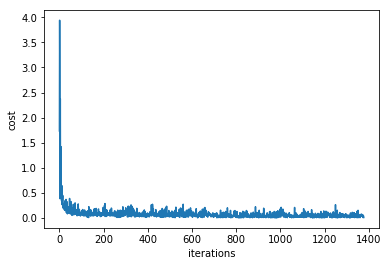

In [38]:
#plotting graph

plt.plot(cost_list)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

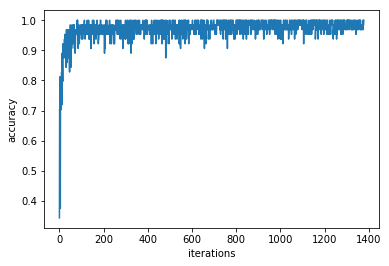

In [39]:
plt.plot(acc_list)
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

# Testing the model

The model is tested on 20% data to check the accuracy.

In [12]:
current_index = 43407

In [13]:
print(current_index)
copy_current_index = current_index
print(copy_current_index)

43407
43407


In [14]:
current_index = copy_current_index
print(current_index)
count_num = 0

43407


In [15]:
#testing

loss = 0.0
acc = 0.0

while current_index + batch_size < len(image_data_list):
    b, l = get_batch()

    score = customVggModel.test_on_batch(b, l)
    print('Test batch score:', score[0])
    print('Test batch accuracy:', score[1], flush = True)
    print(current_index)

    loss += score[0]
    acc += score[1]
    count_num += 1
    print("sum accuracy-{} sum loss-{}".format(acc,loss))
    print('\n')

Test batch score: 0.109879
Test batch accuracy: 0.9375
43470
sum accuracy-0.9375 sum loss-0.10987870395183563


Test batch score: 0.0316694
Test batch accuracy: 0.984375
43533
sum accuracy-1.921875 sum loss-0.1415480673313141


Test batch score: 0.0197599
Test batch accuracy: 1.0
43596
sum accuracy-2.921875 sum loss-0.1613079458475113


Test batch score: 0.0308853
Test batch accuracy: 0.984375
43659
sum accuracy-3.90625 sum loss-0.19219325855374336


Test batch score: 0.0398788
Test batch accuracy: 0.984375
43722
sum accuracy-4.890625 sum loss-0.23207201808691025


Test batch score: 0.00473661
Test batch accuracy: 1.0
43785
sum accuracy-5.890625 sum loss-0.23680862691253424


Test batch score: 0.0218726
Test batch accuracy: 0.984375
43848
sum accuracy-6.875 sum loss-0.2586812498047948


Test batch score: 0.00702829
Test batch accuracy: 1.0
43911
sum accuracy-7.875 sum loss-0.2657095417380333


Test batch score: 0.015404
Test batch accuracy: 1.0
43974
sum accuracy-8.875 sum loss-0.28111

Test batch score: 0.0202258
Test batch accuracy: 1.0
48069
sum accuracy-73.1875 sum loss-2.5473374489229172


Test batch score: 0.00881036
Test batch accuracy: 1.0
48132
sum accuracy-74.1875 sum loss-2.5561478051822633


Test batch score: 0.0142215
Test batch accuracy: 1.0
48195
sum accuracy-75.1875 sum loss-2.5703692964743823


Test batch score: 0.0151694
Test batch accuracy: 1.0
48258
sum accuracy-76.1875 sum loss-2.5855386804323643


Test batch score: 0.0476845
Test batch accuracy: 0.984375
48321
sum accuracy-77.171875 sum loss-2.6332231524866074


Test batch score: 0.00444262
Test batch accuracy: 1.0
48384
sum accuracy-78.171875 sum loss-2.6376657721120864


Test batch score: 0.0136512
Test batch accuracy: 1.0
48447
sum accuracy-79.171875 sum loss-2.651316986652091


Test batch score: 0.0306076
Test batch accuracy: 1.0
48510
sum accuracy-80.171875 sum loss-2.6819245752412826


Test batch score: 0.0141344
Test batch accuracy: 0.984375
48573
sum accuracy-81.15625 sum loss-2.696058959

52605
sum accuracy-144.453125 sum loss-4.872018372640014


Test batch score: 0.0138935
Test batch accuracy: 1.0
52668
sum accuracy-145.453125 sum loss-4.885911893099546


Test batch score: 0.013717
Test batch accuracy: 1.0
52731
sum accuracy-146.453125 sum loss-4.899628867395222


Test batch score: 0.0120757
Test batch accuracy: 1.0
52794
sum accuracy-147.453125 sum loss-4.911704555153847


Test batch score: 0.0255716
Test batch accuracy: 0.984375
52857
sum accuracy-148.4375 sum loss-4.937276117503643


Test batch score: 0.00882761
Test batch accuracy: 1.0
52920
sum accuracy-149.4375 sum loss-4.946103725582361


Test batch score: 0.154223
Test batch accuracy: 0.96875
52983
sum accuracy-150.40625 sum loss-5.100326810032129


Test batch score: 0.0226777
Test batch accuracy: 1.0
53046
sum accuracy-151.40625 sum loss-5.123004492372274


Test batch score: 0.0375228
Test batch accuracy: 0.984375
53109
sum accuracy-152.390625 sum loss-5.160527341067791


Test batch score: 0.0308555
Test batch

In [16]:
copy_loss = loss
copy_acc = acc

In [18]:
#printing

import math
temp = int((0.2*len(image_data_list))/(batch_size))
temp += 1
print(temp)
print(math.ceil(nice_n / batch_size))
print(acc)
print(count_num)

170
848
170.234375
172


In [19]:
loss = loss / count_num
acc = acc / count_num

print('Test score:', loss)
print('Test accuracy:', acc*100)

Test score: 0.0328222877471
Test accuracy: 98.9734738372


# Showing predictions

In [25]:
#Showing predictions


current_index = copy_current_index
acc_avg = 0
counter = 0
wrong_pred_images = []
wrong_pred_labels  = []
correct_labels_of_wrong = []
for i in range(0,20) :
    count = 0
    b,l = get_batch()
    predictions = customVggModel.predict(b,64)
    for list_pred in predictions :
        if np.argmax(list_pred) == np.argmax(l[count]) :
            acc_avg += 1
        else :
            wrong_pred_images.append(image_data_list[current_index+count-batch_size+1])
            wrong_pred_labels.append(np.argmax(list_pred))
            correct_labels_of_wrong.append(np.argmax(l[count]))
        print('predicted = {} and label = {}'.format(np.argmax(list_pred), np.argmax(l[count])))
        count += 1
        counter += 1
    

predicted = 0 and label = 0
predicted = 0 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and la

predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and la

predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and la

predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 0 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 0 and label = 0
predicted = 0 and label = 0
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and label = 1
predicted = 1 and la

WRONGLY CLASSIFIED IMAGES----


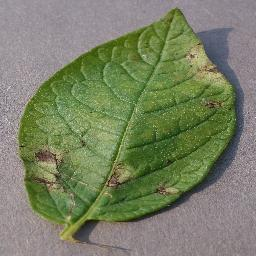

predicted = 0 and label = 1


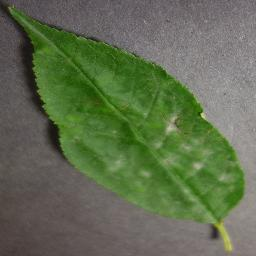

predicted = 0 and label = 1


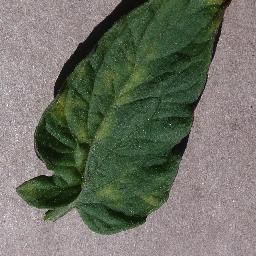

predicted = 1 and label = 0


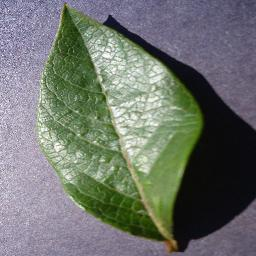

predicted = 0 and label = 1


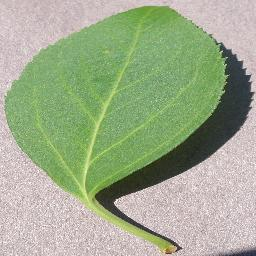

predicted = 0 and label = 1


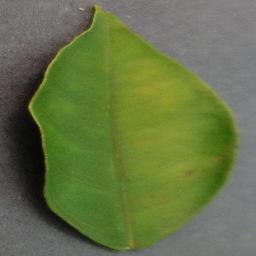

predicted = 1 and label = 0


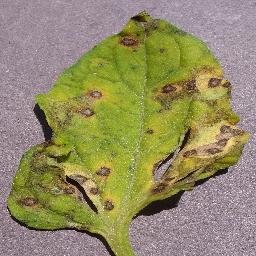

predicted = 1 and label = 0


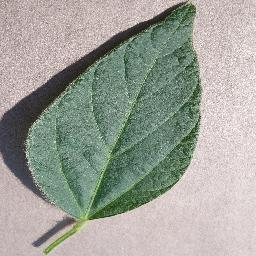

predicted = 0 and label = 1


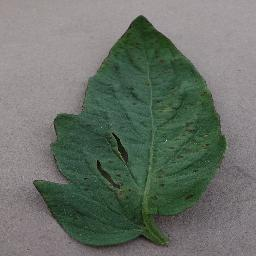

predicted = 1 and label = 0


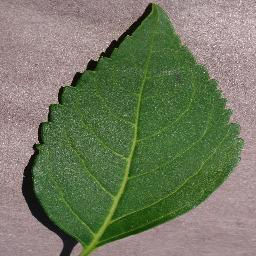

predicted = 1 and label = 0


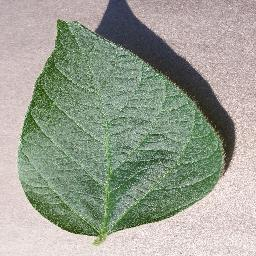

predicted = 0 and label = 1


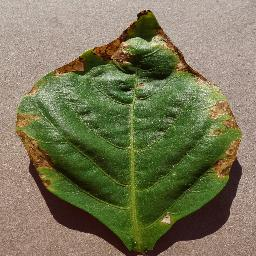

predicted = 0 and label = 1


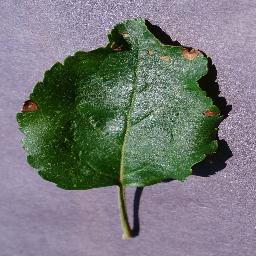

predicted = 0 and label = 1


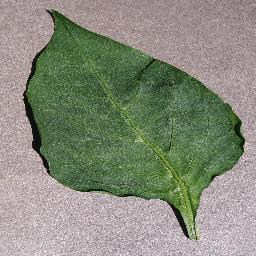

predicted = 1 and label = 0


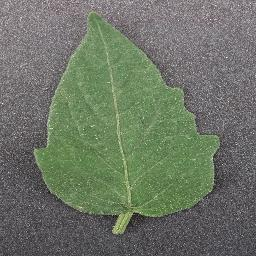

predicted = 0 and label = 1


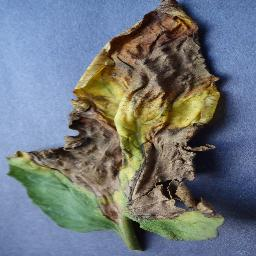

predicted = 0 and label = 1


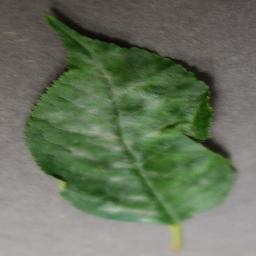

predicted = 0 and label = 1


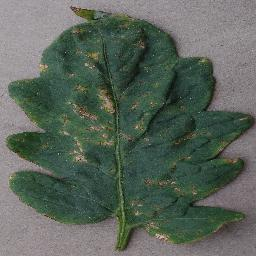

predicted = 0 and label = 1


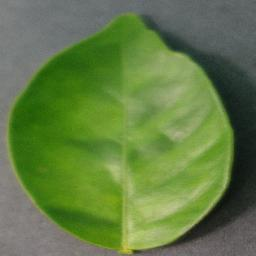

predicted = 1 and label = 0


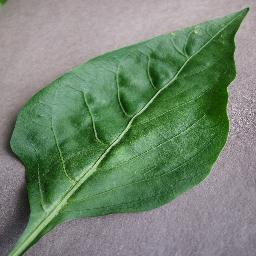

predicted = 0 and label = 1


In [33]:
#showing wrongly predicted images

from IPython.core.display import Image, display

curr_count = 0
ind = 0

print('WRONGLY CLASSIFIED IMAGES----')

for img in wrong_pred_images :
    display(Image(img, width = 100, height = 100))
    print('predicted = {} and label = {}'.format(wrong_pred_labels[curr_count] , correct_labels_of_wrong[curr_count]))
    curr_count += 1

In [32]:
print('accuracy of predictions is : {}'.format(acc_avg/counter*100))

accuracy of predictions is : 98.4375


predicted = 0 and label = 0


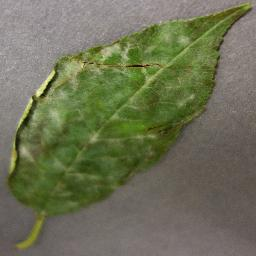

predicted = healthyoriginal = healthy


predicted = 1 and label = 1


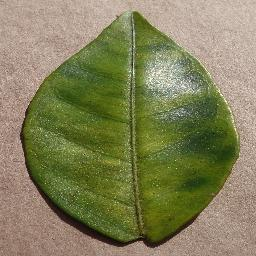

predicted = diseasedoriginal = diseased


predicted = 1 and label = 1


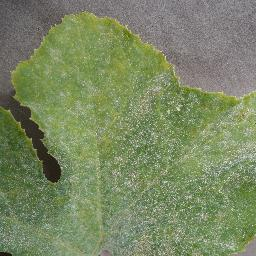

predicted = diseasedoriginal = diseased


predicted = 1 and label = 1


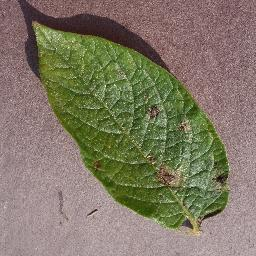

predicted = diseasedoriginal = diseased


predicted = 1 and label = 1


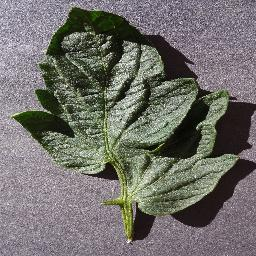

predicted = diseasedoriginal = diseased




In [52]:
#showing images with predictions

ind = 0
curr_count = copy_current_index
for ind in range(0,5) : 
    temp_list = predictions[ind]
    print('predicted = {} and label = {}'.format(np.argmax(temp_list), np.argmax(l[ind])))
    display(Image(image_data_list[curr_count], width = 100, height = 100))
    print('predicted = ' + label_map_dict[np.argmax(temp_list)] + 'original = ' + label_map_dict[np.argmax(l[ind])])
    print('\n')
    curr_count += 1